In [1]:
import pandas as pd
import random
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation

In [2]:
df = pd.read_csv("Train_rev1.csv", encoding='utf-8')

Randomly select 2500 data points (the training dataset train_rev1 contains nearly 250k) for ease of 
analysis. Now perform the tasks in Part A and B.

In [4]:
random.seed(1)
index = random.sample(range(len(df)),2500)

In [5]:
df_2500 = df.iloc[index]

In [6]:
text = []
for i in range(len(df_2500)):
    text.append(df_2500['FullDescription'].iloc[i])
text = ''.join(comment for comment in text)
##example text
text[:250]

u'Chef de Partie  Surrey  Accommodation available  ****K You will be working as part of am ambitious and talented team in this wonderful **** AA Rosette awarded fine dining restaurant and stunning historic hotel. The kitchen and team require an experie'

Part A (basic text mining, just to make sure you are familiar with the fundamentals)

A1. What are the top 5 parts of speech in the job descriptions? How frequently do they appear? How do 
these numbers change if you exclude stopwords?

In [10]:
# remove punctuation
for p in punctuation:
    text=text.replace(p,' ')

In [11]:
# The top 5 parts of speech 
token_text = word_tokenize(text.lower())

text_tag = nltk.pos_tag(token_text)
tag_fd = nltk.FreqDist(tag for (word, tag) in text_tag)
tag_fd.most_common()[:5]

[('NN', 158412), ('JJ', 71009), ('IN', 65401), ('NNS', 51338), ('DT', 50482)]

In [23]:
# remove the stopwords and see how the top 5 POS change
text_filtered = []
for word in token_text:
    if not word in stopwords.words('english'):
        text_filtered.append(word) 
        
text_tag = nltk.pos_tag(text_filtered)
tag_fd = nltk.FreqDist(tag for (word, tag) in text_tag)
tag_fd.most_common()[:5]

[('NN', 152708), ('JJ', 73979), ('NNS', 50740), ('VBG', 25275), ('VBP', 17414)]

A2. Does this data support Zipf’s law? Plot the most common 100 words in the data against the 
theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform 
stemming or lemmatization. 

In [12]:
common_100 = nltk.FreqDist(token_text).most_common()[:100]

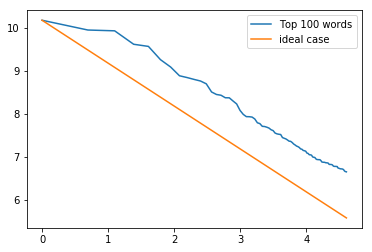

In [25]:
import matplotlib.pyplot as plt
common_100 = pd.DataFrame(common_100)
common_100['rank'] = common_100.index + 1
plt.plot(np.log(common_100['rank']), np.log(common_100[1]), label='Top 100 words')
x = np.linspace(0,np.log(100))
plt.plot(x, np.log(common_100[1][0])-x, label="ideal case")
plt.legend(loc='upper right')
plt.show()

A3. If we remove stopwords and lemmatize the data, what are the 10 most common words? What are 
their frequencies?

In [24]:
#lemmatization
wnl = nltk.WordNetLemmatizer()
text_lemmatized =[wnl.lemmatize(t) for t in text_filtered]
         
nltk.FreqDist(text_lemmatized).most_common()[:10]

[(u'experience', 4380),
 (u'role', 3140),
 (u'team', 2999),
 (u'work', 2906),
 (u'client', 2875),
 (u'business', 2872),
 (u'service', 2472),
 (u'skill', 2438),
 (u'within', 2232),
 (u'working', 2224)]

Part B (predict salary from job description; the idea here is to test the predictive power of text and 
compare it with that of numeric data)

In this section, you will create classification models to predict high (75th percentile and above) or low
(below 75th percentile) salary from the text contained in the job descriptions.

B1. Ignore the job descriptions, and train a model to predict high/low salary from all the numeric 
columns, e.g., part time/full time, contract vs. others, type of job (a lot of dummy variables), location 
(instead of using a huge number of dummy variables, you can use a list of cities in England with highest 
cost of living, and create a 0/1 variable which is 1 if the job is in one of those cities, else 0). Use the Naïve 
Bayes classifier. What is the accuracy of your model? 

In [26]:
def classify_salary(s):
    p_75 =  df_2500['SalaryNormalized'].quantile(0.75)
    if s > p_75:
        return "high"
    else:
        return "low"
df_2500.loc[:,'Salary'] = df_2500['SalaryNormalized'].map(classify_salary)

C:\Users\zjfhz\Anaconda2\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zjfhz\Anaconda2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [27]:
# find these high-cost cities from google
highcost_cities = ['london', 'oxford', 'brighton and hove', 'cambridge', 'bristol', 'portsmouth', 
                   'reading, berkshire', 'edinburgh', 'leicester', 'york', 'exeter', 'aberdeen', 'southampton', 
                   'birmingham', 'manchester', 'leeds', 'ipswich', 'belfast', 'glasgow', 'nottingham', 
                   'kingston upon hull', 'newcastle upon tyne', 'liverpool', 'plymouth']
def classify_city(s):
    if s.lower() in highcost_cities:
        return 1
    else:
        return 0
df_2500.loc[:,'living_cost'] = df_2500['LocationNormalized'].map(classify_city)

In [28]:
ContractType_dummy = pd.get_dummies(df_2500.ContractType)
ContractTime_dummy = pd.get_dummies(df_2500.ContractTime)
Category_dummy = pd.get_dummies(df_2500.Category)

In [35]:
X = df_2500[['living_cost']].join(ContractType_dummy).join(ContractTime_dummy).join(Category_dummy)
y = df_2500['Salary']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB().fit(X_train,y_train)
y_predicted = clf.predict(X_test)

from sklearn import metrics
metrics.accuracy_score(y_test, y_predicted)

0.736

In [36]:
metrics.confusion_matrix(y_test, y_predicted)

array([[ 19, 116],
       [ 16, 349]], dtype=int64)

Now build a classification model with text (full job description) as the only predictor. 

In [90]:
all_words = nltk.FreqDist(w.lower() for w in token_text)
# used the top 8000 words
word_features_8000 = list(all_words)[:8000]

In [91]:
temp = df_2500['FullDescription'].map(lambda s: word_tokenize(s.lower()))
document1 = [el for el in temp]
document2 = []
for i in range(len(document1)):
    document2.append((document1[i], df_2500['Salary'].iloc[i]))

In [92]:
random.shuffle(document2)
def document_features(document): 
    document_words = set(document) 
    features = {}
    for word in word_features_8000:
        features[word] = (word.lower() in document_words)
    return features
featuresets = [(document_features(d), c) for (d,c) in document2]
train_set, test_set = featuresets[500:], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [93]:
print(nltk.classify.accuracy(classifier, test_set))

0.756


In [96]:
test_features = [i[0] for i in test_set]
test_label = [i[1] for i in test_set]
y_pred = []
for feature in test_features:
    y_pred.append(classifier.classify(feature))

In [97]:
metrics.confusion_matrix(test_label, y_pred)

array([[ 71,  47],
       [ 75, 307]], dtype=int64)

In [98]:
classifier.show_most_informative_features(10)

Most Informative Features
                 unified = True             high : low    =     16.8 : 1.0
                coverage = True             high : low    =     16.8 : 1.0
         crossfunctional = True             high : low    =     14.8 : 1.0
              partnering = True             high : low    =     12.8 : 1.0
                      bi = True             high : low    =     11.4 : 1.0
                outlined = True             high : low    =     10.9 : 1.0
            acquisitions = True             high : low    =     10.9 : 1.0
                    soap = True             high : low    =     10.9 : 1.0
             derivatives = True             high : low    =     10.9 : 1.0
                     uml = True             high : low    =     10.9 : 1.0


B3. Train a “hybrid” model to predict high/low salary using both numeric and text data. Show the 
accuracy of the model. 

In [99]:
X = df_2500['FullDescription']
y = df_2500['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
from sklearn.feature_extraction.text import CountVectorizer
 
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

X = df_2500[['living_cost']].join(ContractType_dummy).join(ContractTime_dummy).join(Category_dummy)
y = df_2500['Salary']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)







In [106]:
X_train2.reset_index(drop=True, inplace=True)
X_test2.reset_index(drop=True, inplace=True)

In [107]:
X_train = pd.concat([pd.DataFrame(X_train.toarray()), X_train2], ignore_index=True, axis=1)
X_test = pd.concat([pd.DataFrame(X_test.toarray()), X_test2], ignore_index=True, axis=1)

In [110]:
nb_classifier = BernoulliNB().fit(X_train, y_train)
y_hybrid_predicted = nb_classifier.predict(X_test)
metrics.accuracy_score(y_test, y_hybrid_predicted)

0.768

In [111]:
metrics.confusion_matrix(y_test, y_hybrid_predicted)

array([[ 44,  91],
       [ 25, 340]], dtype=int64)

Thus, the hybrid model provides us the best accuracy and this is not surprising because the job description and the numeric data together give us more information and thus it has a better prediction power!